In [1]:
import sys
main_dir = '../'
sys.path.append(main_dir)

import numpy as np
from functools import lru_cache
import scipy.ndimage as sn
from scipy.optimize import minimize, minimize_scalar
from scipy.interpolate import interp1d
from scipy.integrate import solve_ivp
import scipy.ndimage as sn

import tqdm
import time

import matplotlib.pyplot as plt
import matplotlib.patheffects as pe
from matplotlib.offsetbox import AnchoredText
import matplotlib.gridspec as gridspec
import matplotlib.patches as patches

import importlib as imp

import opennu as on
imp.reload(on)

plt.style.use(main_dir+'sty.mplstyle')
cols = ['#0C5DA5', '#00B945', '#FF9500', '#FF2C00', '#845B97', '#474747', '#9e9e9e']

#### SPN limited, ideal, constraint for $^{129}$Xe

In [177]:
de, c2, c2l, _ = on.find_delta(10, 0.15, p_init=1, T2=10, Nshots=10, seed=42, d_init=1e3, d_fin=1e16, ndelta=100,
                 chi2_crit=3.84, squid_noise_ratio=0.0, sample='Xe',mode='sum')
ff = 10*100**(3/2)
print("delta: %.2e\n"%(de/ff)) # Including T2=1000 s, Nshots=1000

Max rate is Gamma_-= 5.616e+00
delta: 3.43e+07



#### SPN limited, ideal, constraint for $^{1}$H

In [5]:
de, c2, c2l, _ = on.find_delta(10, 0.1, p_init=1, T2=10, Nshots=1000, seed=42, d_init=1e9, d_fin=1e16, ndelta=100,
                 chi2_crit=5, squid_noise_ratio=0.0, sample='H', verb=True, mode='m1', opt=True)
ff = 100**(1)
print("delta: %.2e\n"%(de/ff)) # Including T2=1000 s linear scaling

At B=0.10, I get w=1.760e-08
g+/g- = 0.9813801
Passed w=1.760e-08, optimal w=1.046e-08,  used w=1.046e-08
g+/g- = 0.9888876
Max rate is Gamma_-= 1.307e-01 Hz
delta: 3.43e+10



#### CASPEr future setup: $R=1$ cm, ${\cal F}_{\rm SQUID}=50$, $p=50$\%

In [4]:
de, c2, c2l, _ = on.find_delta(1, 0.15, p_init=0.5, T2=10, Nshots=1000, seed=42, d_init=1e8, d_fin=1e16, ndelta=100,
                 chi2_crit=2.71, squid_noise_ratio=50.0, mode='sum')
ff = 100**(3/2)
print("delta: %.2e\n"%(de/ff)) # Including T2=1000 s, Nshots=1000

delta: 3.13e+10



#### Using $\langle{\cal J}^2_x\rangle$

In [148]:
de, c2, c2l, _ = on.find_deltax(10, 0.15, p_init=1, T2=10, Nshots=1000, seed=42, d_init=1e15, d_fin=1e31, ndelta=100,
                 chi2_crit=2.71, squid_noise_ratio=0.0, mode='sum')
ff = 100**(3/2)
print("delta: %.2e\n"%(de/ff)) # Including T2=1000 s

delta: 6.58e+17



#### Check rates of   [2408.04021]

In [162]:
gr, gm, _ = on.compute_ratio(0.1, 1.046e-8, mode='m1', A=1, Z=1)

R = 10
n = 3e22
knu = 5.3e-4*2*np.pi*8065
N = 4*np.pi/3*R**3*n
fsup = 4*(knu*R)**2

print("Gamma_tot = %.5f"%((gm+gr*gm)*N**2/fsup))
print("Gamma_net = %.5f"%((gm-gr*gm)*N**2/fsup))

2.388355688525581e-48
Gamma_tot = 0.25999
Gamma_net = 0.00145


#### Timescales 

In [173]:
gr, gm, _ = on.compute_ratio(0.15, 1.046e-8, mode='sum', A=129, Z=54)
N = 1e25
print(gm)
print(gr)
print(1/(N**2*gm))
print(1/(N*gm))

R = 1
n = 1.3e22
knu = 5.3e-4*2*np.pi*8065
N = 4*np.pi/3*R**3*n
print(gm*N**2/fsup)

5.047823621328157e-46
0.9944087318125037
1.9810517859118162e-05
1.9810517859118167e+20
5.187855657172826e-06


In [161]:
gm

1.144631206650376e-48

## $R$ dependence

#### Serial

In [15]:
# rl = np.geomspace(0.005, 10, 100)
# dell_r = []
# dell_r2 = []
# for r in tqdm.tqdm(rl):
#     de, _, _  = on.find_delta(r, 0.16, p_init=1, T2=1, Nshots=10, seed=42, d_init=1e11, d_fin=1e25, ndelta=200, B=0.1, opt=True)
#     de2, _, _ = on.find_delta(r, 0.16, p_init=1, T2=1, Nshots=10, seed=23, d_init=1e11, d_fin=1e25, ndelta=200, B=0.1, opt=False)
#     dell_r.append(de)
#     dell_r2.append(de2)

# dell_r = np.array(dell_r)
# dell_r2 = np.array(dell_r2)

#### Parallel 

In [37]:
import concurrent.futures

rl = np.geomspace(0.005, 10, 100)

def worker(r):
    import opennu as on
    de, _, _, wu  = on.find_delta(r, 0.15, p_init=1, T2=1, Nshots=10, seed=42,
                              d_init=1e11, d_fin=1e30, ndelta=200, B=0.1, opt=True, mode='sum')
    de2, _, _, wu2 = on.find_delta(r, 0.15, p_init=1, T2=1, Nshots=10, seed=23,
                              d_init=1e11, d_fin=1e30, ndelta=200, B=0.1, opt=False, mode='sum')
    return de, de2, wu, wu2

dell_r = []
dell_r2 = []
wl = []
wl2 = []

with concurrent.futures.ProcessPoolExecutor() as executor:
    results = list(tqdm.tqdm(executor.map(worker, rl), total=len(rl)))

dell_r, dell_r2, wl, wl2 = zip(*results)
dell_r = np.array(dell_r)
dell_r2 = np.array(dell_r2)
wl= np.array(wl)
wl2 = np.array(wl2)

100%|█████████████████████████████████████████| 100/100 [00:15<00:00,  6.50it/s]


In [39]:
np.savetxt(main_dir+'/data/R_dep_opt_v2.txt', np.column_stack([rl, sn.gaussian_filter(dell_r, sigma=1)]))
np.savetxt(main_dir+'/data/R_dep_v2.txt',     np.column_stack([rl, sn.gaussian_filter(dell_r2, sigma=1)]))

In [49]:
# ss = 1

# norm = 1000**(3/2)*10

# r1 = np.geomspace(0.001, 0.03, 30)
# r2 = np.geomspace(0.05, 10, 30)
# r3 = np.geomspace(0.1, 10, 30)
# r4 = np.geomspace(0.2, 10, 30)

# fig, ax = plt.subplots(figsize=(7,7))


# plt.loglog(rl, sn.gaussian_filter(dell_r, sigma=ss)/norm, label=r'$\omega_0=p_{\nu}/(m_1 R)$', c='#004f98', lw=4)
# plt.loglog(rl, sn.gaussian_filter(dell_r2, sigma=ss)/norm, label=r'$\omega_0=5\times 10^{-9}$ eV', c='#144814',lw=4)

# plt.loglog(rl, rl**(-3/2)*1e8, c='k', label='$R^{-3/2}$', ls='--')

# plt.xlim(5e-3, 10)
# plt.ylim(1e3, 1e19)
# plt.xlabel(r'$R$ (cm)')
# plt.ylabel(r'C$\nu$B overdensity, $\delta_{\nu}$')
# plt.legend()

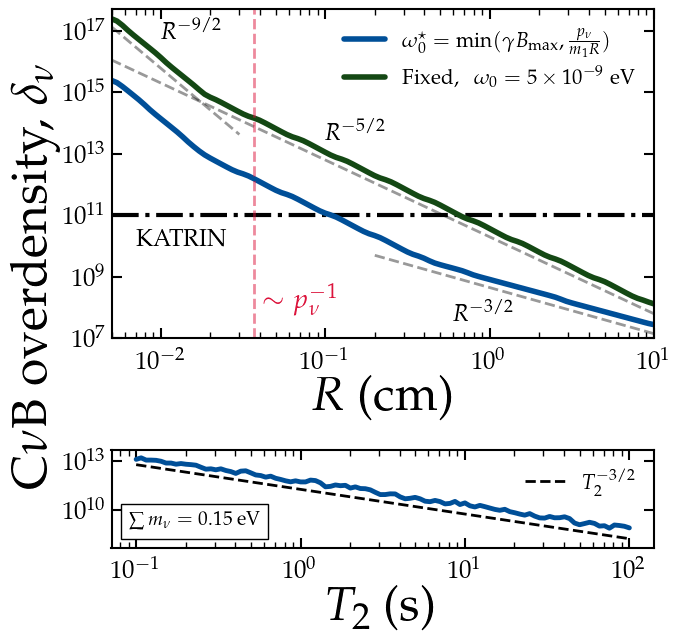

In [70]:
ss = 1

norm = 1000**(3/2)*10

r1 = np.geomspace(0.001, 0.03, 30)
r2 = np.geomspace(0.05, 10, 30)
r3 = np.geomspace(0.1, 10, 30)
r4 = np.geomspace(0.2, 10, 30)

fig = plt.figure(figsize=(7,7))

gs = gridspec.GridSpec(2, 1, height_ratios=[1,0.3],  hspace=0.52)

ax0 = fig.add_subplot(gs[0])
ax1 = fig.add_subplot(gs[1])


rl, der = np.loadtxt(main_dir+'/data/R_dep_opt_v2.txt', unpack=True)
rl, der2 = np.loadtxt(main_dir+'/data/R_dep_v2.txt', unpack=True)
#plt.loglog(rl, sn.gaussian_filter(dell_r, sigma=ss)/norm, label=r'$\omega_0=p_{\nu}/(m_1 R)$', c='#004f98', lw=4)
#plt.loglog(rl, sn.gaussian_filter(dell_r2, sigma=ss)/norm, label=r'$\omega_0=5\times 10^{-9}$ eV', c='#144814',lw=4)
ax0.loglog(rl, der/norm, label=r'$\omega^\star_0=\min(\gamma B_{\rm max}, \frac{p_{\nu}}{m_1 R})$', c='#004f98', lw=4)
ax0.loglog(rl, der2/norm, label=r'Fixed, ~~$\omega_0=5\times 10^{-9}$ eV', c='#144814',lw=4)


ck = 'k'
ax0.loglog(rl, rl/rl*1e11, c=ck, ls='dashdot', zorder=0)
lw1 = 2
alp = 0.4
ax0.loglog(r1, 6e6*r1**(-9/2),  ls='--', c='k', lw=lw1, alpha=alp)
ax0.loglog(rl, 2e10*rl**(-5/2), ls='--', c='k', lw=lw1, alpha=alp)
#ax0.loglog(r1, 7e4*r1**(-9/2),  ls='--', c='k', lw=lw1, alpha=alp)
#ax0.loglog(rl, 1.8e8*rl**(-5/2), ls='--', c='k', lw=lw1, alpha=alp)
ax0.loglog(r4, 4.5e8*r4**(-3/2),  ls='--', c='k', lw=lw1, alpha=alp)
ax0.axvline(1/27, alpha=0.5, lw=2, c='crimson', ls='--')
ax0.text(0.042, 1e8, r'$\sim p^{-1}_\nu$', c='crimson')

ttfs = 17

ax0.text(7e-3, 1e10, 'KATRIN', fontsize=17, c=ck)
ax0.text(0.01, 6e16, r'$R^{-9/2}$', fontsize=ttfs)
ax0.text(0.1,  3e13, r'$R^{-5/2}$', fontsize=ttfs)
ax0.text(0.6,  4e7, r'$R^{-3/2}$', fontsize=ttfs)

ax0.set_xlim(5e-3, 10)
ax0.set_ylim(1e7, 5e17)

ax0.set_xlabel(r'$R$ (cm)', labelpad=0)
ax0.legend(loc=1)

t2l, me_t = np.loadtxt(main_dir+'data/T2_dep.txt', unpack=True)
de, _, _ , _  = on.find_delta(10, 0.15, T2=0.1, Nshots=100, seed=24, d_init=1e8, d_fin=1e14, ndelta=200, mode='sum')
norm11 = de/np.sqrt(10)
norm = norm11

ax1.loglog(t2l, me_t*norm, lw=3.5, c='#004f98')
ax1.loglog(t2l, 0.015*t2l**(-1.5)*norm, ls='--', label=r'$T_2^{-3/2}$', c='k', alpha=1, lw=2)

ax1.set_xlabel(r'$T_2$ (s)', labelpad=0)
#ax1.set_ylabel(r'$\delta_{\nu}$ [a.u.]')
ax1.legend()
ax1.set_ylim(5e7, 5e13)

text_box = AnchoredText(
    #r"$m_1=0.05$ eV", 
    r"$\sum m_\nu=0.15$ eV", 
    loc=3,            
    frameon=True,                
    prop=dict(size=14)
)
ax1.add_artist(text_box)


label = fig.supylabel(r'C$\nu$B overdensity, $\delta_{\nu}$', fontsize=36)
label.set_position((-0.02,0.5)) 
plt.show()
fig.savefig(main_dir+'plots/deltaR_T2_scaling.pdf', bbox_inches='tight')

### Additonal $R$ dependence checks

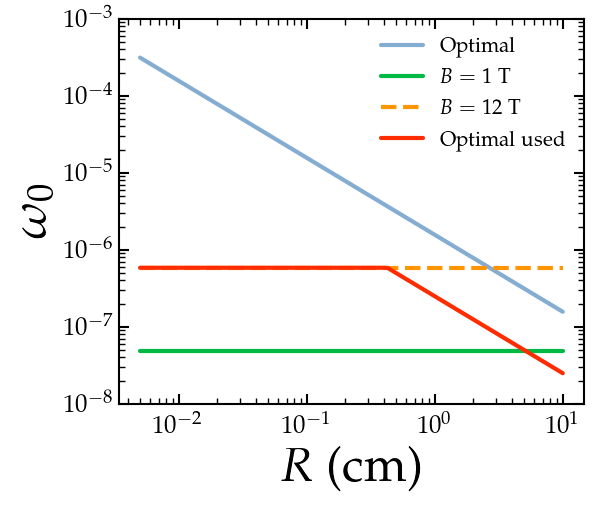

In [71]:
_, _, masses = on.compute_ratio(0.15, 1e-9)
m1 = masses[0]

eVHz   = 1 / 6.58e-16              
B1  = 1
w1     = 2 * np.pi * 11.78e6 * B1 / eVHz  

B2  = 12
w2     = 2 * np.pi * 11.78e6 * B2 / eVHz  

w_opt = 5.3e-4/m1/rl/8065

fig = plt.figure(figsize=(6,5))

plt.loglog(rl, w_opt, label='Optimal', alpha=0.5)
plt.loglog(rl, rl/rl*w1, label='$B=1$ T')
plt.loglog(rl, rl/rl*w2, label='$B=12$ T', ls='--')
plt.loglog(rl, wl, label='Optimal used')

plt.xlabel(r'$R$ (cm)')
plt.ylabel(r'$\omega_0$')

plt.ylim(1e-8, 1e-3)
plt.legend()

In [10]:
grl = []
gml = []

rl = np.geomspace(0.005, 1000, 100)

_, _, masses = on.compute_ratio(0.15, 1e-9)
m1 = masses[0]

for i in tqdm.tqdm(range(len(rl))):
    w0 = w_opt = 5.3e-4/m1/rl[i]/8065
    gr, gm, _ = on.compute_ratio(0.15, w0)
    grl.append(gr)
    gml.append(gm)
grl = np.array(grl)
gml = np.array(gml)

100%|█████████████████████████████████████████| 100/100 [00:46<00:00,  2.15it/s]


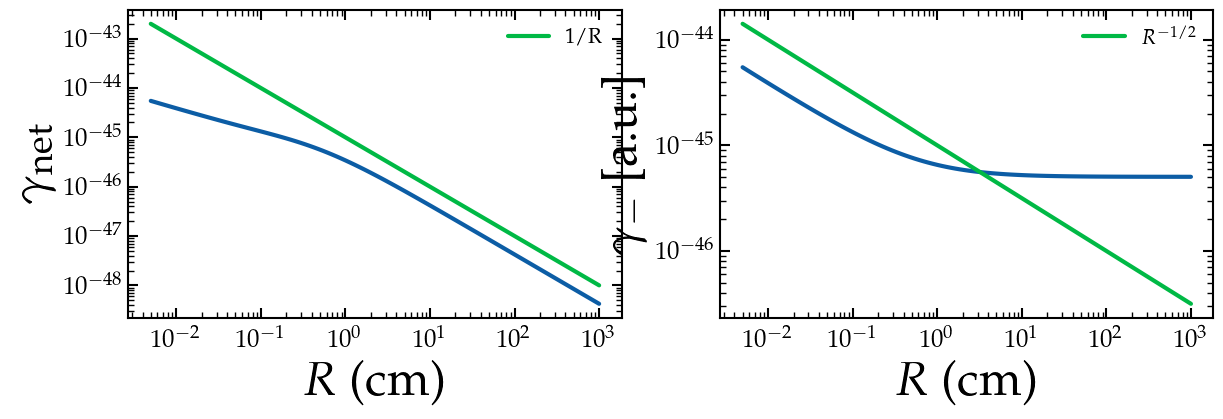

In [11]:
fig, ax = plt.subplots(1,2, figsize=(14,4))

gpl = gml*grl

ax[0].loglog(rl, gml-gpl)
ax[0].loglog(rl, 1e-45*rl**(-1), label='1/R')
ax[0].set_xlabel(r'$R$ (cm)')
ax[0].set_ylabel(r'$\gamma_{\rm net}$')
#ax[0].set_ylim(5e-2, 5)
ax[0].legend()

ax[1].loglog(rl, gml)
ax[1].loglog(rl, 1e-45*rl**(-1/2), label=r'$R^{-1/2}$')
ax[1].set_xlabel(r'$R$ (cm)')
ax[1].set_ylabel(r'$\gamma_-$ [a.u.]')
ax[1].legend()
plt.show()

# $m_1$ dependence

#### Serial

In [ ]:
# mnl = np.linspace(0.005, 1, 50)
# dell_m = []
# dell_m_0 = []

# for m in tqdm.tqdm(mnl):
#     de, c2, _ = on.find_delta(1, m, T2=10, Nshots=10, seed=42, d_init=1e7, d_fin=1e16, ndelta=100, squid_noise_ratio=50.0)
#     dell_m.append(de)
#     de, c2, _ = on.find_delta(10, m, T2=10, Nshots=10, seed=42, d_init=1e7, d_fin=1e16, ndelta=100, squid_noise_ratio=0.0)
#     dell_m_0.append(de)

# dell_m = np.array(dell_m)
# dell_m_0 = np.array(dell_m_0)

#### Parallel

In [72]:
import concurrent.futures

mnl = np.linspace(0.001, 1, 100)

def worker_m(m):
    import opennu as on
    de, _, _, _ = on.find_delta(1,   m, T2=10, Nshots=10, seed=42, d_init=1e5, d_fin=1e16, ndelta=150, squid_noise_ratio=50.0)
    de2, _, _, _ = on.find_delta(10, m, T2=10, Nshots=10, seed=42, d_init=1e5, d_fin=1e16, ndelta=150, squid_noise_ratio=0.0)
    return de, de2

dell_m = []
dell_m_0 = []

with concurrent.futures.ProcessPoolExecutor() as executor:
    res = list(tqdm.tqdm(executor.map(worker_m, mnl), total=len(mnl)))

dell_m, dell_m_0 = zip(*res)
dell_m = np.array(dell_m)
dell_m_0 = np.array(dell_m_0)

100%|█████████████████████████████████████████| 100/100 [00:45<00:00,  2.19it/s]


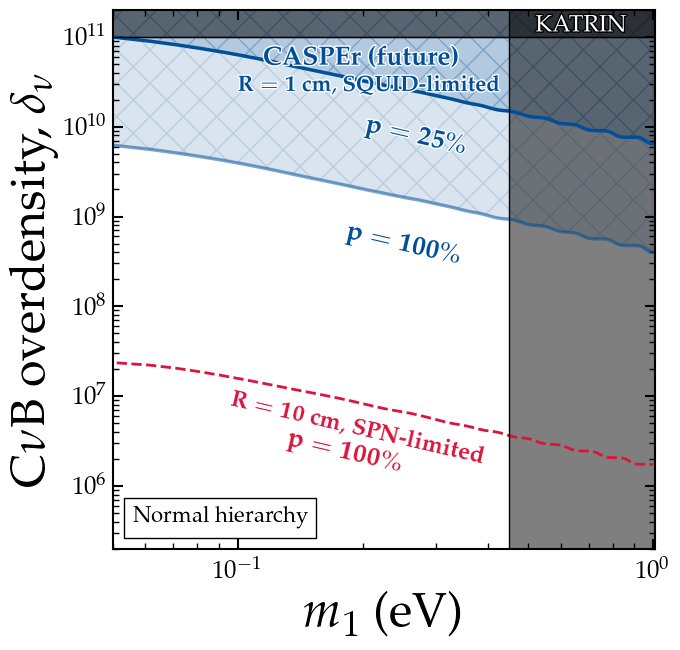

In [73]:
fig, ax = plt.subplots(figsize=(7,7))


c1 = '#004f98'
c2 = 'navy'

al = 0.05

f1 = 100**(3/2)*10*(1*0.25)**2     # T2=1000, Nshots=1000, p=0.25, FSQUID=50
f2 = 100**(3/2)*10                 # T2=1000, Nshots=1000, p=1,   FSQUID=50 
f4 = 100**(3/2)*10                 # T2=1000, Nshots=1000, p=1,   FSQUID=0  

si = 2

dm = sn.gaussian_filter(dell_m, sigma=si)
dm_0 = sn.gaussian_filter(dell_m_0, sigma=si)

plt.loglog(mnl, dm/f1, c=c1, lw=2.5)
plt.fill_between(mnl, dm/f1, 1e16*np.ones(len(mnl)), alpha=0.3, color=c1, hatch='X')

plt.loglog(mnl, dm/f2, c=c1, lw=2.5, alpha=0.5)
plt.fill_between(mnl, dm/f2, dm/f1, alpha=0.15, color=c1, hatch='X')

tc = plt.text(0.115,4.9e10,r'{\bf CASPEr (future)}', fontsize=19, c=c1)
tc.set_path_effects([pe.Stroke(linewidth=2, foreground='w'),
                     pe.Normal()])

tc2 = plt.text(0.1,2.5e10,r'${\bf R=1}$ {\bf cm}, {\bf SQUID-limited}', fontsize=16, c=c1)
tc2.set_path_effects([pe.Stroke(linewidth=2, foreground='w'),
                     pe.Normal()])

tp1 = plt.text(0.2, 5e9,r'${\bf p=25\%}$', fontsize=19,c=c1, alpha=1, rotation=-13)
tp2 = plt.text(0.18,3e8,r'${\bf p=100\%}$', fontsize=19,c=c1, alpha=1, rotation=-13)
tp1.set_path_effects([pe.Stroke(linewidth=2, foreground='w'),
                     pe.Normal()])
tp2.set_path_effects([pe.Stroke(linewidth=2, foreground='w'),
                     pe.Normal()])

plt.loglog(mnl, dm_0/f4, c='crimson', lw=2, ls='--')
#plt.text(0.055,5.5e7,r'${\bf R=10}$ {\bf cm}', fontsize=17,c='crimson', rotation=0)
plt.text(0.095, 1.8e6,r'${\bf R=10}$ {\bf cm},~{\bf SPN-limited}', fontsize=17,c='crimson', rotation=-13)
tp2 = plt.text(0.13,1.5e6,r'${\bf p=100\%}$', fontsize=19,c='crimson', alpha=1, rotation=-13)

mm = np.geomspace(1e-3, 2,100)
mm2 = np.geomspace(1e-3, 0.45,100)
plt.loglog(mm, mm/mm*1e11, c='k', lw=1)
plt.fill_between(mm, 1e11,  1e15, alpha=0.5, color='k')

yy = np.geomspace(1e3,2e11,100)
plt.axvline(0.45, c='k', lw=1)
plt.fill_betweenx(yy, 0.45, 2, color='k', alpha=0.5, lw=0.001)
tk = plt.text(5.2e-1, 1.15e11, 'KATRIN', fontsize=17, alpha=1, c='w', rotation=0)
#tk = plt.text(6e-1, 1e10, 'KATRIN', fontsize=19, alpha=1, c='w', rotation=-90)
tk.set_path_effects([pe.Stroke(linewidth=2, foreground='black'),
                     pe.Normal()])

text_box = AnchoredText(
    fr"Normal hierarchy", 
    loc='lower left',            
    frameon=True,                
    prop=dict(size=16)
)
ax.add_artist(text_box)

plt.xlabel(r'$m_1$ (eV)')
plt.ylabel(r'C$\nu$B overdensity, $\delta_{\nu}$')
plt.xlim(5e-2, 1.01)
plt.ylim(2e5, 2e11)
plt.show()
#fig.savefig(main_dir+'plots/deltanu_m1.pdf', bbox_inches='tight')

In [70]:
ls ../data

fsquid_dep.txt   mass_optimal.txt  R_dep_opt_v2.txt  R_dep_v2.txt
mass_casper.txt  R_dep_opt_v1.txt  R_dep_v1.txt      T2_dep.txt


In [69]:
np.savetxt(main_dir+'/data/mass_casper.txt', np.column_stack([mnl, dm]))
np.savetxt(main_dir+'/data/mass_optimal.txt', np.column_stack([mnl, dm_0]))

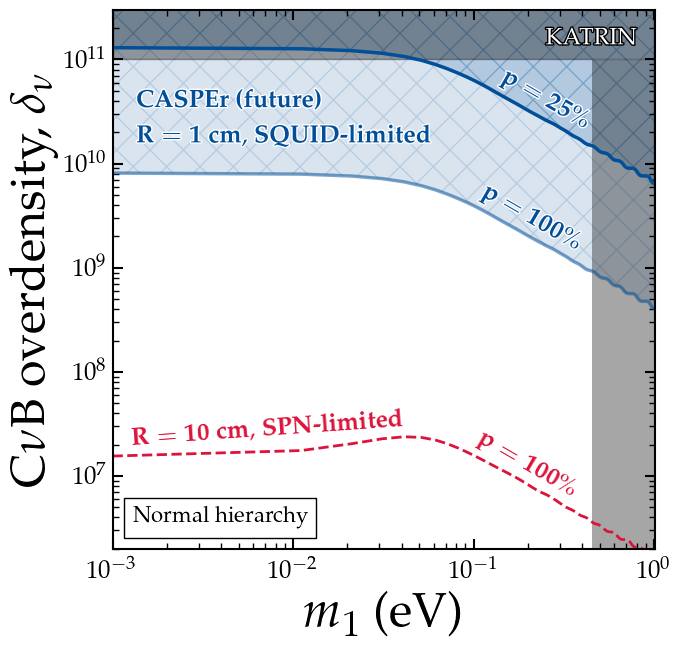

In [152]:
fig, ax = plt.subplots(figsize=(7,7))


c1 = '#004f98'
c2 = 'navy'

al = 0.05

f1 = 100**(3/2)*10*(1*0.25)**2     # T2=1000, Nshots=1000, p=0.25, FSQUID=50
f2 = 100**(3/2)*10                 # T2=1000, Nshots=1000, p=1,   FSQUID=50 
f4 = 100**(3/2)*10                 # T2=1000, Nshots=1000, p=1,   FSQUID=0  

si = 2

dm = sn.gaussian_filter(dell_m, sigma=si)
dm_0 = sn.gaussian_filter(dell_m_0, sigma=si)

plt.loglog(mnl, dm/f1, c=c1, lw=2.5)
plt.fill_between(mnl, dm/f1, 1e16*np.ones(len(mnl)), alpha=0.3, color=c1, hatch='X')

plt.loglog(mnl, dm/f2, c=c1, lw=2.5, alpha=0.5)
plt.fill_between(mnl, dm/f2, dm/f1, alpha=0.15, color=c1, hatch='X')

tc = plt.text(0.00135,3.5e10,r'{\bf CASPEr (future)}', fontsize=18, c=c1)
tc.set_path_effects([pe.Stroke(linewidth=2, foreground='w'),
                     pe.Normal()])

tc2 = plt.text(0.00135,1.6e10,r'${\bf R=1}$ {\bf cm}, {\bf SQUID-limited}', fontsize=18, c=c1)
tc2.set_path_effects([pe.Stroke(linewidth=2, foreground='w'),
                     pe.Normal()])

tp1 = plt.text(0.135, 2.2e10,r'${\bf p=25\%}$', fontsize=18,c=c1, alpha=1, rotation=-30)
tp2 = plt.text(0.105,1.5e9,r'${\bf p=100\%}$', fontsize=18,c=c1, alpha=1, rotation=-30)
tp1.set_path_effects([pe.Stroke(linewidth=2, foreground='w'),
                     pe.Normal()])
tp2.set_path_effects([pe.Stroke(linewidth=2, foreground='w'),
                     pe.Normal()])

plt.loglog(mnl, dm_0/f4, c='crimson', lw=2, ls='--')
#plt.text(0.055,5.5e7,r'${\bf R=10}$ {\bf cm}', fontsize=17,c='crimson', rotation=0)
plt.text(0.00125, 2e7,r'${\bf R=10}$ {\bf cm},~{\bf SPN-limited}', fontsize=18,c='crimson', rotation=4)
tp2 = plt.text(0.1,6.5e6,r'${\bf p=100\%}$', fontsize=18,c='crimson', alpha=1, rotation=-30)


alphak = 0.35
mm = np.geomspace(1e-3, 2,100)
mm2 = np.geomspace(1e-3, 0.45,100)
#plt.loglog(mm, mm/mm*1e11, c='k', lw=1)
plt.fill_between(mm, 1e11,  1e15, alpha=alphak, color='k')

yy = np.geomspace(1e3,9.9e10,100)
#plt.axvline(0.45, c='k', lw=1)
plt.fill_betweenx(yy, 0.45, 2, color='k', alpha=alphak, lw=0.001)



tk = plt.text(2.5e-1, 1.4e11, 'KATRIN', fontsize=17, alpha=1, c='w', rotation=0)
#tk = plt.text(6e-1, 1e10, 'KATRIN', fontsize=19, alpha=1, c='w', rotation=-90)
tk.set_path_effects([pe.Stroke(linewidth=2, foreground='black'),
                     pe.Normal()])

text_box = AnchoredText(
    fr"Normal hierarchy", 
    loc='lower left',            
    frameon=True,                
    prop=dict(size=16)
)
ax.add_artist(text_box)

plt.xlabel(r'$m_1$ (eV)')
plt.ylabel(r'C$\nu$B overdensity, $\delta_{\nu}$')
plt.xlim(1e-3, 1.01)
plt.ylim(2e6, 3e11)
plt.show()
fig.savefig(main_dir+'plots/deltanu_m1_v2.pdf', bbox_inches='tight')

In [111]:
gy = 11.78e6
eVHz   = 1 / 6.58e-16                   # eV/Hz conversion
w0     = 2 * np.pi * gy * 1 / eVHz      # eV
print(w0)

w0     = gy * 1 / eVHz      # eV
print(w0)

4.8702477280422696e-08
7.75124e-09


In [117]:
1/241799050402293

4.135665538538099e-15

In [116]:
2*np.pi/eVHz

4.134335932124168e-15

## Different sample materials

In [108]:
import concurrent.futures

mnl = np.geomspace(0.0001, 1, 100)

def worker_ms(m):
    de1, _, _, _ = on.find_delta(10, m, T2=1, Nshots=10, d_init=1e7, d_fin=1e17, ndelta=100, squid_noise_ratio=0.0, sample='Xe')
    de2, _, _, _ = on.find_delta(10, m, T2=1, Nshots=10, d_init=1e7, d_fin=1e17, ndelta=100, squid_noise_ratio=0.0, sample='He')
    de3, _, _, _ = on.find_delta(10, m, T2=1, Nshots=10, d_init=1e7, d_fin=1e17, ndelta=100, squid_noise_ratio=0.0, sample='H')
    return de1, de2, de3

dell_m1 = []
dell_m2 = []
dell_m3 = []

with concurrent.futures.ProcessPoolExecutor() as executor:
    res = list(tqdm.tqdm(executor.map(worker_ms, mnl), total=len(mnl)))

dell_m1, dell_m2, dell_m3 = zip(*res)
dell_m1 = np.array(dell_m1)
dell_m2 = np.array(dell_m2)
dell_m3 = np.array(dell_m3)

100%|█████████████████████████████████████████| 100/100 [00:32<00:00,  3.08it/s]


In [149]:
# fig, ax = plt.subplots(figsize=(7,7))


# c1 = '#004f98'
# c2 = 'navy'

# al = 0.05

# f1 = 1000**(3/2)*10

# si = 1

# dm1 = sn.gaussian_filter(dell_m1, sigma=si)
# dm2 = sn.gaussian_filter(dell_m2, sigma=si)
# dm3 = sn.gaussian_filter(dell_m3, sigma=si)


# plt.loglog(mnl, dm1/f1, lw=2.5, c='C0', ls='--', label=r'$R=10$ cm, ~~$^{129}$Xe')
# plt.loglog(mnl, dm2/f1, lw=2.5, c='C1', ls='--', label=r'$R=10$ cm, ~~$^{3}$He')
# plt.loglog(mnl, dm3/f1, lw=2.5, c='C2', ls='--', label=r'$R=10$ cm, ~~$^{1}$H')


# pair_abs = np.array([[0.0005177804903556527, 1657834326.7389877],
# [0.07786413634147336, 1688824073.6577861],
# [0.10204972715309346, 1714415017.035888],
# [0.15311700072452655, 1741263547.1626225],
# [0.27763041550136264, 1845905783.0879643],
# [0.4318588848004305, 1955728771.2530704],
# [0.6363877327067246, 2130669274.627967],
# [0.97222098328159, 2387681798.680744],
# [1.3944324890661355, 2601000694.336299],
# [1.98204807003649, 2833283426.0644603]])

# plt.loglog(pair_abs[:,0]/1e3, pair_abs[:,1],c='crimson', label='Pair absorption (Bauer)')

# eVHz   = 1 / 6.58e-16 
# wmax_Xe =  2 * np.pi * 11.78e6 * 12 / eVHz
# mmax_Xe = 5.3e-4/(10*8065*wmax_Xe)
# plt.axvline(mmax_Xe, c='C0', ls='--', lw=1.5, alpha=0.6)

# wmax_He =  2 * np.pi * 32.43e6 * 12 / eVHz
# mmax_He = 5.3e-4/(10*8065*wmax_He)
# plt.axvline(mmax_He, c='C1', ls='--', lw=1.5, alpha=0.6)

# wmax_H =  2 * np.pi * 42.58e6 * 12 / eVHz
# mmax_H = 5.3e-4/(10*8065*wmax_H)
# plt.axvline(mmax_H, c='C2', ls='--', lw=1.5, alpha=0.6)


# plt.xlim(1e-6, 2.01)
# plt.ylim(2e6, 2e16)

# # plt.xlim(5e-2, 1.01)
# # plt.ylim(2e6, 2e11)

# plt.legend()

# plt.xlabel(r'$m_1$ (eV)')
# plt.ylabel(r'C$\nu$B overdensity, $\delta_{\nu}$')
# plt.show()

In [74]:
g1 = []
g2 = []

for i in tqdm.tqdm(range(len(mnl))):
    gr, gm, _ = on.compute_ratio(mnl[i], 1e-9, mode='m1')
    g1.append(gr)
    g2.append(gm)

g1 = np.array(g1)
g2 = np.array(g2)

100%|█████████████████████████████████████████| 100/100 [00:55<00:00,  1.80it/s]


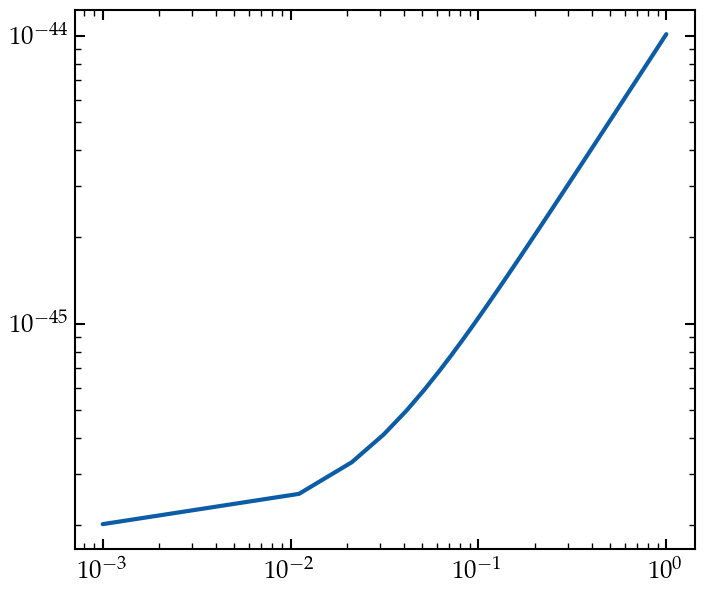

In [105]:
plt.loglog(mnl, g2)
plt.show()

## $p$ dependence

In [40]:
pl = np.geomspace(0.001, 1, 20)
dell_p = []
dell_p2 = []
for p in tqdm.tqdm(pl):
    de, _, _  = on.find_delta(10, 0.16, p_init=p, T2=1, Nshots=100, seed=42, d_init=1e7, d_fin=1e19, ndelta=50)
    de2, _, _ = on.find_delta(10, 0.16, p_init=p, T2=1, Nshots=100, seed=23, d_init=1e7, d_fin=1e19, ndelta=50)
    dell_p.append(de)
    dell_p2.append(de2)

dell_p = np.array(dell_p)
dell_p2 = np.array(dell_p2)

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:44<00:00,  2.22s/it]


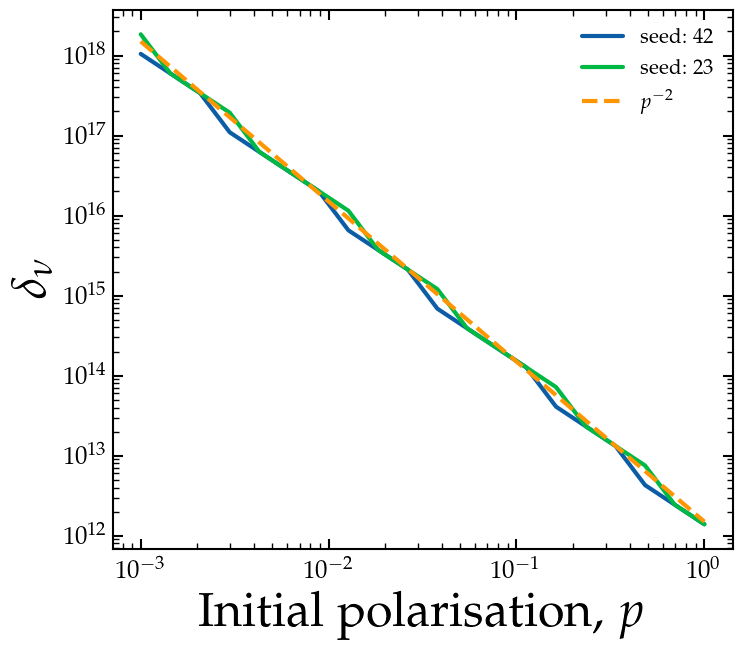

In [41]:
plt.loglog(pl, dell_p, label='seed: 42')
plt.loglog(pl, dell_p2, label='seed: 23')

plt.loglog(pl, 1.5e12*pl**(-2), ls='--', label=r'$p^{-2}$')

plt.xlabel(r'Initial polarisation, $p$')
plt.ylabel(r'$\delta_{\nu}$')
plt.legend()
plt.show()

## ${\cal F}_{\rm SQUID}$ dependence

In [44]:
sql = np.geomspace(0.001, 200, 100)
dell_sq = []
dell_sq2 = []
for sq in tqdm.tqdm(sql):
    de, c2, _  = find_delta(10, 0.16,  T2=0.1, Nshots=10, seed=23, d_init=1e11, d_fin=1e22, ndelta=200, squid_noise_ratio=sq)
    de2, c2, _  = find_delta(10, 0.16, T2=0.1, Nshots=10, seed=42, d_init=1e11, d_fin=1e22, ndelta=200, squid_noise_ratio=sq)
    dell_sq.append(de)
    dell_sq2.append(de2)

dell_sq = np.array(dell_sq)
dell_sq2 = np.array(dell_sq2)

100%|██████████████████████████████████████████████████████████| 100/100 [01:57<00:00,  1.18s/it]


In [7]:
# dell_sq3 = dell_sq
# dell_sq4 = dell_sq2

In [45]:
me_sq = np.mean(np.array([dell_sq/dell_sq[0], dell_sq2/dell_sq2[0], dell_sq3/dell_sq3[0], dell_sq4/dell_sq4[0]]), axis=0)

In [10]:
np.savetxt(main_dir+'data/fsquid_dep.txt', np.column_stack([sql, me_sq]))

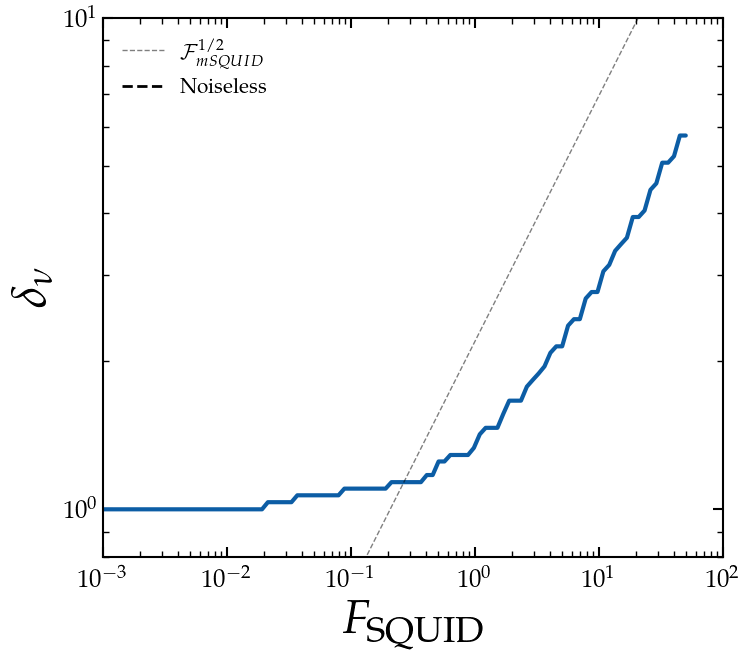

In [16]:
# plt.loglog(sql, dell_sq/dell_sq[0], label='seed: 42')
# plt.loglog(sql, dell_sq2/dell_sq2[0], label='seed: 23')
plt.loglog(sql, me_sq)
plt.loglog(sql, 2.2*sql**(1/2), ls='--', lw=1, alpha=0.5,c='k', label='${\cal F}_{\rm SQUID}^{1/2}$')

de0, _, _ = find_delta(10, 0.16,  T2=1, Nshots=100, seed=42, d_init=1e11, d_fin=1e22, ndelta=200, squid_noise_ratio=0)

plt.hlines(de0, xmin=1e-3, xmax=50, ls='--', color='k', label='Noiseless', lw=2)
plt.xlim(1e-3,100)
plt.ylim(0.8,10)
plt.xlabel(r'$F_{\rm SQUID}$')
plt.ylabel(r'$\delta_{\nu}$')
plt.legend()
plt.show()

## $T_2$ dependence

In [54]:
# t2l = np.geomspace(0.1, 100, 100)
# dell_t1 = []
# dell_t2 = []
# dell_t3 = []
# dell_t4 = []
# for tt in tqdm.tqdm(t2l):
#     de, _, _ , _  = on.find_delta(10, 0.16, T2=tt, Nshots=100, seed=24, d_init=1e8, d_fin=1e14, ndelta=200)
#     dell_t1.append(de)
#     de, _, _ , _  = on.find_delta(10, 0.16, T2=tt, Nshots=100, seed=11, d_init=1e8, d_fin=1e14, ndelta=200)
#     dell_t2.append(de)
#     de, _, _, _  = on.find_delta(10, 0.16, T2=tt, Nshots=100, seed=24, d_init=1e8, d_fin=1e14, ndelta=200)
#     dell_t3.append(de)
#     de, _, _ , _ = on.find_delta(10, 0.16, T2=tt, Nshots=100, seed=11, d_init=1e8, d_fin=1e14, ndelta=200)
#     dell_t4.append(de)

# dell_t1 = np.array(dell_t1)
# dell_t2 = np.array(dell_t2)
# dell_t3 = np.array(dell_t3)
# dell_t4 = np.array(dell_t4)
# me_t = np.mean(np.array([dell_t1, dell_t2, dell_t3, dell_t4]), axis=0)

In [150]:
# np.savetxt(main_dir+'data/T2_dep.txt', np.column_stack([t2l, me_t]))

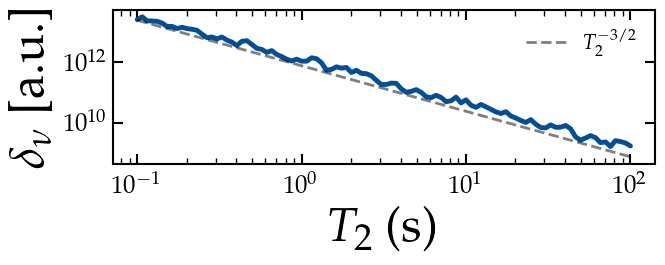

In [68]:
t2l, me_t = np.loadtxt(main_dir+'data/T2_dep.txt', unpack=True)

fig = plt.figure(figsize=(7,2))

norm = 25677204425975.86

plt.loglog(t2l, me_t*norm, lw=3.5, c='#004f98')
plt.loglog(t2l, 0.03*t2l**(-1.5)*norm, ls='--', label=r'$T_2^{-3/2}$', c='k', alpha=0.5, lw=2)

plt.xlabel(r'$T_2$ (s)')
plt.ylabel(r'$\delta_{\nu}$ [a.u.]')
plt.legend()
plt.show()
#fig.savefig(main_dir+'plots/T2_small.pdf', bbox_inches='tight')

## $N_{\rm shots}$ dependence

In [21]:
de, _, _ = find_delta(10, 0.16, T2=0.01, Nshots=1000, seed=24, d_init=1e12, d_fin=1e17, ndelta=200)
print("%.3e"%de)

3.449e+14


In [32]:
nsl = np.geomspace(5, 1000, 100)
nsl_int = [int(ns) for ns in nsl]

d, d2, d3 = [], [], []

for see in [11, 25, 43, 51]:    
    dell_seed, dell2_seed, dell3_seed = [], [], []

    for ns in tqdm.tqdm(nsl_int):
        de, _, _ = find_delta(10, 0.16, T2=0.01, Nshots=ns, seed=see, d_init=1e12, d_fin=1e19, ndelta=200)
        dell_seed.append(de)

        de, _, _ = find_delta(10, 0.16, T2=0.01, Nshots=ns, seed=see, d_init=1e12, d_fin=1e19, ndelta=200, squid_noise_ratio=1)
        dell2_seed.append(de)

        de, _, _ = find_delta(10, 0.16, T2=0.01, Nshots=ns, seed=see, d_init=1e12, d_fin=1e19, ndelta=200, squid_noise_ratio=10)
        dell3_seed.append(de)

    d.append(dell_seed)
    d2.append(dell2_seed)
    d3.append(dell3_seed)

d = np.array(d)     # shape: (n_seeds, len(nsl))
d2 = np.array(d2)
d3 = np.array(d3)

me_ns1 = np.mean(d, axis=0)
me_ns2 = np.mean(d2, axis=0)
me_ns3 = np.mean(d3, axis=0)

100%|██████████████████████████████████████████████████████████| 100/100 [02:53<00:00,  1.73s/it]


In [ ]:
np.savetxt(main_dir+'data/Ns1_dep.txt', np.column_stack([nsl, me_ns1]))
np.savetxt(main_dir+'data/Ns2_dep.txt', np.column_stack([nsl, me_ns2]))
np.savetxt(main_dir+'data/Ns3_dep.txt', np.column_stack([nsl, me_ns3]))

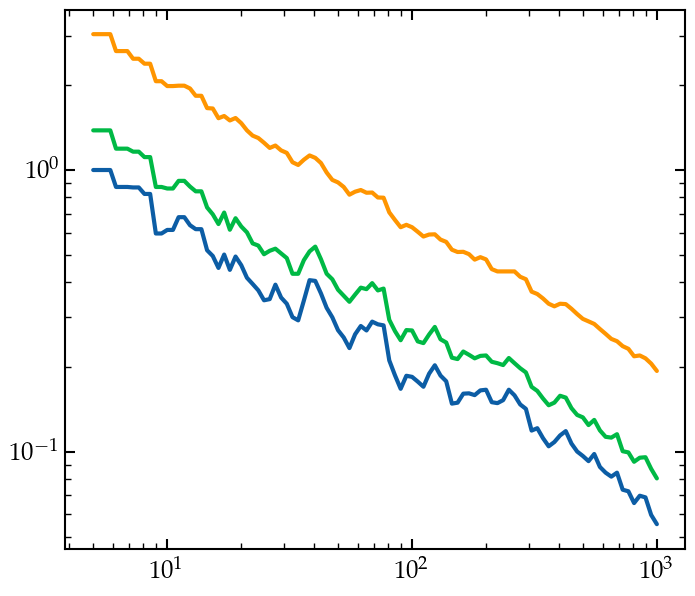

In [34]:
plt.loglog(nsl,me_ns1/me_ns1[0])
plt.loglog(nsl, me_ns2/me_ns1[0])
plt.loglog(nsl, me_ns3/me_ns1[0])
#plt.loglog(nsl, 2*nsl**(-0.5), ls='--')

In [430]:
# sql, me_sq = np.loadtxt(main_dir+'/data/fsquid_dep.txt', unpack=True)
# t2l, me_t  = np.loadtxt(main_dir+'/data/T2_dep.txt', unpack=True)
# rl,  me_r  = np.loadtxt(main_dir+'/data/R_dep.txt', unpack=True)

In [ ]:
fig, ax = plt.subplots(1, 3, figsize=(14, 2.6))
fig.subplots_adjust(wspace=0.01, hspace=0.34)
fs = 16


#-----------------------------------------------------------------------------------------------------------
ax[0].loglog(sql, me_sq)
ax[0].loglog(sql, 0.6*sql**(1/2), ls='--', lw=1.5, alpha=1,c='k', label=r'${\cal F}_{\rm SQUID}^{1/2}$')
ax[0].loglog(sql, sql/sql, c='k', ls='--', lw=1, alpha=0.5)

ax[0].set_xlim(1e-3, 200)
ax[0].set_ylim(0.6, 20)
ax[0].legend(fontsize=fs, frameon=False)
ax[0].set_xlabel(r'${\cal F}_{\rm SQUID}$', fontsize=25)
ax[0].set_ylabel(r'$\delta_\nu$ [a.u.]')
#ax[0].tick_params(labelleft=False, labelright=True)


# #-----------------------------------------------------------------------------------------------------------
ax[1].loglog(t2l, me_t)
ax[1].loglog(t2l, 0.05*t2l**(-1.5), ls='--', label=r'$T_2^{-3/2}$', c='k',lw=1.5)
ax[1].legend(fontsize=fs, frameon=False)
ax[1].set_xlabel(r'$T_2$ (s)', fontsize=25)
ax[1].tick_params(labelleft=False, labelright=False)
#ax[1].set_ylabel(r'$\delta_\nu$ [a.u.]')

# #-----------------------------------------------------------------------------------------------------------

ax[2].loglog(nsl,me_ns1/me_ns1[0])#, label=r'${\cal F}_{\rm SQUID}=10$')
ax[2].loglog(nsl, me_ns2/me_ns1[0])#, label=r'${\cal F}_{\rm SQUID}=10$')
ax[2].loglog(nsl, me_ns3/me_ns1[0])#, label=r'${\cal F}_{\rm SQUID}=10$')
ax[2].loglog(nsl, 2*nsl**(-0.5), ls='--', c='k', lw=1.5, alpha=1, label=r'$N_{\rm shots}^{-1/2}$')
ax[2].text(145, 4,r'${\cal F}_{\rm SQUID}=10$',c='C2', fontsize=16)
ax[2].text(145, 2,r'${\cal F}_{\rm SQUID}=1$',c='C1', fontsize=16)
ax[2].text(145, 1,r'${\cal F}_{\rm SQUID}=0$',c='C0', fontsize=16)
ax[2].set_xlabel(r'$N_{\rm shots}$', fontsize=25)
ax[2].set_ylim(0.05, 10)
ax[2].legend(fontsize=fs, loc=3)
ax[2].tick_params(labelleft=False, labelright=True)

# plt.tight_layout()
plt.show()
#fig.savefig(main_dir+'plots/delta_scaling.pdf', bbox_inches='tight')

## Other

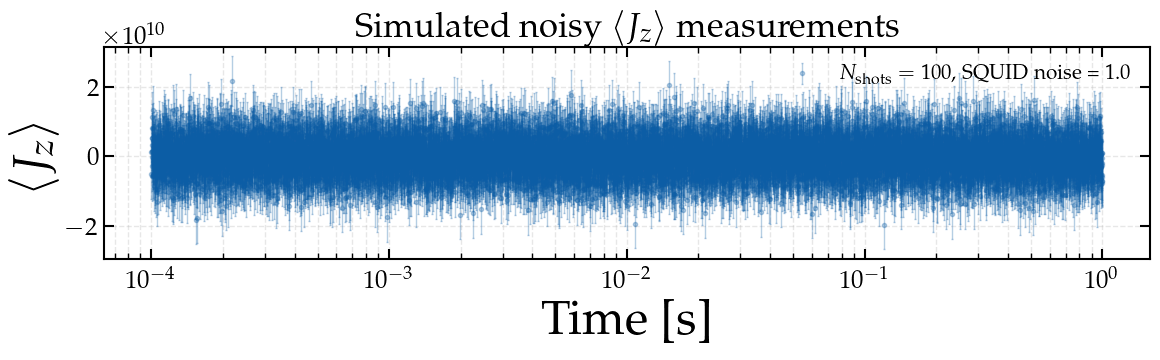

In [78]:
N = int(1e22)
Nshots = 100
sampf = 1e4
tf = 1
ti = 1 / sampf
squid_noise_ratio = 1.0  # Adjust as needed
sk = 1  # skip factor for plotting

# Time grid
n_times = int((tf - ti) * sampf)
t_exp = np.geomspace(ti, tf, n_times)

# Simulate noisy measurements of J_z (mean zero)
np.random.seed(42)
jz_true_mean = 0.0
jz_true_std = np.sqrt(N / 4)
Jz_samples = np.random.normal(jz_true_mean, jz_true_std, size=(n_times, Nshots))
Jz_mean_exp = np.mean(Jz_samples, axis=1)

# Total error: quantum + SQUID noise
sigma_jz = np.sqrt(N / 4 / Nshots * (1 + squid_noise_ratio)) * np.ones(n_times)

# Plot
plt.figure(figsize=(12, 4))
plt.errorbar(t_exp[::sk], Jz_mean_exp[::sk], yerr=sigma_jz[::sk],
             fmt='o', label=fr'$N_{{\rm shots}}={Nshots}$, SQUID noise = {squid_noise_ratio}',
             alpha=0.3, markersize=3, lw=1, capsize=1)

plt.xscale('log')
plt.xlabel("Time [s]")
plt.ylabel(r"$\langle J_z \rangle$")
plt.title("Simulated noisy $\langle J_z \\rangle$ measurements")
plt.legend()
plt.grid(True, which='both', ls='--', alpha=0.3)
plt.tight_layout()
plt.show()